In [1]:
import os
from pathlib import Path
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nutil.plot import paperStyle
from tqdm import tqdm
import sys
import librosa.display
import umap
from scipy import signal

sys.path.append("../src/")
from cross_validate import get_df_metadata
from dataloader import SpokenDataLoader

/data/du92wufe/.conda/envs/airway/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2024-01-11 10:29:35.075679: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Lengths

/tmp/ipykernel_3192324/2360506128.py:9: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df["Language"].cat.reorder_categories(["German", "English", "French", "Mandarin"], inplace=True)


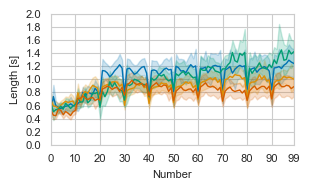

In [112]:
df = pd.read_csv("../results/audio_lengths.csv")

with paperStyle():
    # divide length by 44100 to get length in seconds
    df["Length"] = df["Length"] / 44100

    # order languages: German, English, French, Mandarin
    df["Language"] = df["Language"].astype("category")
    df["Language"].cat.reorder_categories(["German", "English", "French", "Mandarin"], inplace=True)

    sns.set_palette("colorblind")
    sns.set_style("whitegrid")
    plt.figure(figsize=(3.2, 2))
    ax = sns.lineplot(x="Number", y="Length", hue="Language", data=df, errorbar="sd", err_style="band", linewidth=1, legend=None)
    ax.set_xlabel("Number")
    ax.set_ylabel("Length [s]")
    #plt.title("Mean audio length of spoken numbers in different languages")
    #plt.legend(loc="lower right")
    x_ticks = np.arange(0, 101, 10)
    x_ticks[-1] = 99
    plt.xticks(x_ticks)
    plt.xticks()
    plt.xlim(0, 99)
    plt.yticks(np.arange(0, 2.1, 0.2))
    plt.ylim(0, 2)
    plt.tight_layout()

    plt.savefig("../results/audio_lengths_plot.svg", dpi=300)
    plt.show()

## F0 frequencies

In [114]:
df = pd.read_csv(Path("../results/audio_frequencies.csv"))

# soft df by frequency from high to low
df = df.sort_values(by="Frequency", ascending=False)

# sort by speakers
df = df.sort_values(by="Speaker")
df.head()

,Language,Number,Frequency,Speaker
8487,German,65,195.198660,Arnold
10119,Mandarin,16,180.648760,Arnold
11015,Mandarin,44,166.242104,Arnold
2439,English,76,235.115873,Arnold
8327,German,60,195.724847,Arnold


/tmp/ipykernel_3192324/2420912247.py:8: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df["Language"].cat.reorder_categories(["German", "English", "French", "Mandarin"], inplace=True)


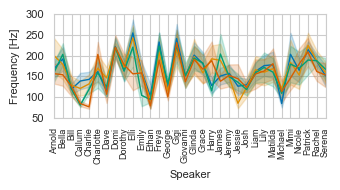

In [127]:
df = pd.read_csv(Path("../results/audio_frequencies.csv"))

#sort the df by mean frequency over all numbers
df = df.sort_values(by="Frequency", ascending=False)
df = df.sort_values(by="Speaker")

df["Language"] = df["Language"].astype("category")
df["Language"].cat.reorder_categories(["German", "English", "French", "Mandarin"], inplace=True)

with paperStyle():
    sns.set_palette("colorblind")
    sns.set_style("whitegrid")
    plt.figure(figsize=(3.5, 2))
    ax = sns.lineplot(x="Speaker", y="Frequency", hue="Language", data=df, errorbar="sd", linewidth=1, legend=None)
    ax.set_ylabel("Frequency [Hz]")
    #sns.despine()
    #plt.legend(loc="upper right")
    plt.xticks(rotation=90)

    # lower x ticks size
    plt.tick_params(axis='x', which='major', labelsize=6.5)

    plt.ylim(50, 300)
    #plt.xticks(np.arange(0, 101, 10))
    plt.xlim(0, 31)
    plt.yticks(np.arange(50, 301, 50))
    plt.tight_layout()
    plt.savefig("../results/audio_frequencies_plot.svg", dpi=300)
    plt.show()

# Manifold Learning

### Load data and fit_transform UMAP

In [131]:
df = get_df_metadata()
df["language"] = df["language"].astype("category")
df["language"].cat.reorder_categories(["German", "English", "French", "Mandarin"], inplace=True)
dl = SpokenDataLoader(None, batch_size=1)
data = dl.load_waveforms_as_numpy(df)

mel_specs = []
for i in tqdm(range(len(data)), desc="Computing mel spectrograms"):
    mel_spec = librosa.feature.melspectrogram(y=data[i], sr=8000, n_fft=2048, hop_length=512, n_mels=128, fmax=8000)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    mel_specs.append(mel_spec)
    break

/tmp/ipykernel_3192324/1028571893.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df["language"].cat.reorder_categories(["German", "English", "French", "Mandarin"], inplace=True)
Computing mel spectrograms:   0%|          | 0/12800 [00:00<?, ?it/s]/data/du92wufe/.conda/envs/airway/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
Computing mel spectrograms:   0%|          | 0/12800 [00:00<?, ?it/s]


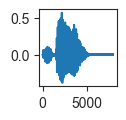

In [142]:
plt.figure(figsize=(1, 1))
plt.plot(data[0])
plt.savefig("../results/waveform.svg", dpi=300)
plt.show()

In [2]:
df = get_df_metadata()
df["language"] = df["language"].astype("category")
df["language"].cat.reorder_categories(["German", "English", "French", "Mandarin"], inplace=True)
dl = SpokenDataLoader(None, batch_size=1)
data = dl.load_waveforms_as_numpy(df)

mel_specs = []
for i in tqdm(range(len(data)), desc="Computing mel spectrograms"):
    mel_spec = librosa.feature.melspectrogram(y=data[i], sr=8000, n_fft=2048, hop_length=512, n_mels=128, fmax=8000)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    mel_specs.append(mel_spec)

specs_reshaped = []
for i in tqdm(range(len(mel_specs)), desc="Reshaping spectrograms"):
    specs_reshaped.append(mel_specs[i].reshape(-1))

reducer = umap.UMAP()
embedding = reducer.fit_transform(np.array(specs_reshaped))

/tmp/ipykernel_3192324/2823166946.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df["language"].cat.reorder_categories(["German", "English", "French", "Mandarin"], inplace=True)
Computing mel spectrograms:   0%|          | 0/12800 [00:00<?, ?it/s]/data/du92wufe/.conda/envs/airway/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
Reshaping spectrograms: 100%|██████████| 12800/12800 [00:00<00:00, 567919.05it/s]


In [3]:
# add embedding to df
df["embedding_x"] = embedding[:, 0]
df["embedding_y"] = embedding[:, 1]

In [57]:
# make copy of df and remove every 10th row
df_copy = df.copy()
# shuffle rows
df_copy = df_copy.sample(frac=1)
df_copy = df_copy.iloc[::2, :]

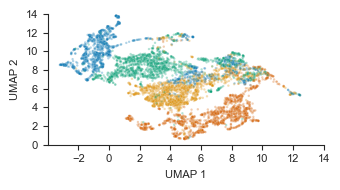

In [62]:
with paperStyle():
    plt.figure(figsize=(3.5, 2))
    #sns.set_style("whitegrid")
    sns.scatterplot(x=df_copy["embedding_x"], y=df_copy["embedding_y"], hue=df_copy["language"], legend=None, palette="colorblind", alpha=0.3, s=3)
    sns.despine()
    #plt.legend(loc="upper right")
    plt.xticks(np.arange(-2, 15, 2))
    plt.yticks(np.arange(0, 15, 2))
    plt.ylim(0, 14)
    plt.xlim(-4, 14)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.tight_layout()
    #plt.savefig("../results/umap_embedding_languages.svg", dpi=300)
    plt.show()

### Plot UMAP embedding colorcoded for each speaker

In [59]:
# assign a number between 0 and 1 to each speaker
speakers = df["speaker"].unique()
labels = np.linspace(0, 1, len(speakers))

# replace speaker names with labels
for i in range(len(speakers)):
    df_copy["speaker"] = df_copy["speaker"].replace(speakers[i], labels[i])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


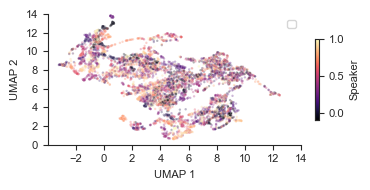

In [71]:
#plot and use labels as color
with paperStyle():
    plt.figure(figsize=(3.8, 2))
    #sns.set()
    #sns.set_style("whitegrid")
    
    ax = sns.scatterplot(x=df_copy["embedding_x"], y=df_copy["embedding_y"], hue=df_copy["speaker"], legend=None, palette="magma", alpha=0.3, s=3)
    norm = plt.Normalize(df_copy['speaker'].max(), df_copy['speaker'].min()) 
    sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.015)
    sns.despine()
    plt.xticks(np.arange(-2, 15, 2))
    plt.yticks(np.arange(0, 15, 2))
    plt.ylim(0, 14)
    plt.xlim(-4, 14)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(loc="upper right")
    plt.tight_layout()
    #plt.savefig("../results/umap_embedding_speakers.svg", dpi=300)
    plt.show()

### Plot UMAP embedding colorcoded for each number

In [63]:
numbers = df["number"].unique()
labels = np.linspace(0, 1, len(numbers))

# replace speaker names with labels
for i in range(len(numbers)):
    df_copy["number"] = df_copy["number"].replace(numbers[i], labels[i])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


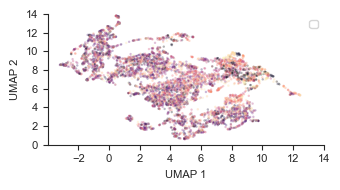

In [70]:
with paperStyle():
    plt.figure(figsize=(3.5, 2))
    #sns.set()

    ax = sns.scatterplot(x=df_copy["embedding_x"], y=df_copy["embedding_y"], hue=df_copy["number"], legend=None, palette="magma", alpha=0.3, s=3)
    sns.despine()
    norm = plt.Normalize(df_copy['number'].min(), df_copy['number'].max())
    sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
    sm.set_array([])
    #plt.colorbar(sm, ax = plt.gca())
    plt.xticks(np.arange(-2, 15, 2))
    plt.yticks(np.arange(0, 15, 2))
    plt.ylim(0, 14)
    plt.xlim(-4, 14)

    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig("../results/umap_embedding_numbers.svg", dpi=300)
    plt.show()

### Load AudioMNIST data

In [75]:
AUDIO_MNIST_PATH = Path("../../AudioMNIST/data/")

In [128]:
audio_mnist_specs = []
for folder in tqdm(AUDIO_MNIST_PATH.iterdir()):
    if not folder.is_dir():
        continue
    for file in folder.iterdir():
        if file.suffix == ".wav":
            y, sr = librosa.load(file, sr=None)
            y = signal.resample(y, 8000, axis=0)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=8000, n_fft=2048, hop_length=512, n_mels=128, fmax=8000)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            
            audio_mnist_specs.append(mel_spec.reshape(-1))

0it [00:00, ?it/s]/data/du92wufe/.conda/envs/airway/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
61it [03:33,  3.50s/it]


In [129]:
audio_mnist_embedding = reducer.transform(np.array(audio_mnist_specs))

In [130]:
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=df["language"], legend="full", palette="colorblind", alpha=0.3, s=3)
# plot audio mnist embedding
sns.scatterplot(x=audio_mnist_embedding[:, 0], y=audio_mnist_embedding[:, 1], color="black", alpha=0.3, s=3)
plt.show()

KeyError: 'language'